# 20211012-simpoints
Evaluate IPCs over simpoints for the base prefetchers.

In [9]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import attrdict
import matplotlib.pyplot as plt

In [10]:
def load_simpoint_weights(simpoints_file, trace):
    """Load simpoint weights for a given trace."""
    simpoints = pd.read_csv(simpoints_file)
    simpoints.columns = ['trace', 'weight']
    tr_points = simpoints[simpoints.trace.str.contains(trace)]
    
    weights = np.array(tr_points.weight.array)
    return weights

In [11]:
trace = 'mcf'
simpoints_file = 'data/simpoint-weights/spec17.csv'
simpoint_weights = load_simpoint_weights(simpoints_file, trace)
print(f'{trace} simpoint weights:', simpoint_weights)

mcf simpoint weights: [0.126582  0.0141772 0.128608  0.0116456 0.0313924 0.0349367 0.440506
 0.0688608 0.142785 ]


In [12]:
def parse_champsim_result_file(f, max_instruction_num=None, min_instruction_interval=0):
    data = {
        'instructions': [],
        'cycles': [],
        'heartbeat_ipcs': [],
        'cumulative_ipcs': [],
        'cumulative_sim_times': [],
    }
    
    last_instruction = 0
    warmups_completed = 0 # 0 = none, 1 = CPU, 2 = CPU + prefetch
    for line in f:
        line_tokens = line.split(' ')
        
        # Only append data after the prefetch warmup completes.
        # DEBUG - Hardcoded stop condition (for now. It should stop
        # automatically, but for some reason it doesn't).
        if 'Warmup complete' in line:
            warmups_completed += 1
        
        if 'Heartbeat' in line:
            #print(line)
            instructions = int(line_tokens[line_tokens.index('instructions:') + 1])
            cycles = int(line_tokens[line_tokens.index('cycles:') + 1])
            heartbeat_ipc = float(line_tokens[line_tokens.index('heartbeat') + 2])
            cumulative_ipc = float(line_tokens[line_tokens.index('cumulative') + 2])
            cumulative_sim_time = int(line_tokens[line_tokens.index('time:') + 1]) * 3600 \
                              + int(line_tokens[line_tokens.index('time:') + 3]) * 60 \
                              + int(line_tokens[line_tokens.index('time:') + 5]) \

            # DEBUG - Temporary fix until we can figure out why
            # ChampSim runs too long.
            if max_instruction_num and instructions >= max_instruction_num: 
                warmups_completed = 0
            
            if warmups_completed >= 2 and instructions - last_instruction > min_instruction_interval:
                data['instructions'].append(instructions)
                data['cycles'].append(cycles)
                data['heartbeat_ipcs'].append(heartbeat_ipc)
                data['cumulative_ipcs'].append(cumulative_ipc)
                data['cumulative_sim_times'].append(cumulative_sim_time)
                last_instruction = instructions
    
    return attrdict.AttrDict(data)

def load_champsim_base_results(base, tracename, **kwargs):
    base_path = base + f'/*{tracename}*.txt'
    data = {}
    print('\nLoading ChampSim base prefetcher results from:', base_path)
    variation_paths = glob.glob(base_path)
    for path in variation_paths:
        if '-bo' in os.path.basename(path):
            variation_name = 'bo'
        elif '-sisb_bo' in os.path.basename(path):
            variation_name = 'sisb-bo'
        elif '-sisb-' in os.path.basename(path):
            variation_name = 'sisb'
        elif '-no' in os.path.basename(path):
            variation_name = 'no-prefetcher'
        else:
            continue
            
        print(f'Found variation: {variation_name}')
        with open(path, 'r') as f:
            data[variation_name] = parse_champsim_result_file(
                f, **kwargs
            )
    return data

In [12]:
base_data = []
for i in range(len(simpoint_weights)):
    base_data.append(load_champsim_base_results(f'data/base/', f'mcf-s{i}', max_instruction_num=500000000, min_instruction_interval=3900000))


Loading ChampSim base prefetcher results from: data/base//*mcf-s0*.txt
Found variation: bo
Found variation: no-prefetcher
Found variation: sisb

Loading ChampSim base prefetcher results from: data/base//*mcf-s1*.txt
Found variation: bo
Found variation: no-prefetcher

Loading ChampSim base prefetcher results from: data/base//*mcf-s2*.txt
Found variation: bo
Found variation: no-prefetcher

Loading ChampSim base prefetcher results from: data/base//*mcf-s3*.txt
Found variation: bo
Found variation: no-prefetcher

Loading ChampSim base prefetcher results from: data/base//*mcf-s4*.txt
Found variation: bo
Found variation: no-prefetcher

Loading ChampSim base prefetcher results from: data/base//*mcf-s5*.txt
Found variation: bo
Found variation: no-prefetcher

Loading ChampSim base prefetcher results from: data/base//*mcf-s6*.txt
Found variation: bo
Found variation: no-prefetcher
Found variation: sisb-bo
Found variation: sisb

Loading ChampSim base prefetcher results from: data/base//*mcf-s7*.tx

---
# Weighted geometric mean IPCs
- Take the weighted geometric mean of IPCs for the given trace, using the simpoint weights.

In [30]:
def get_simpoint_ipcs(results):
    num_simpoints = len(results)
    simpoint_ipcs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs organized by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            if pf == 'no-prefetcher': # DEBUG - dummy until we get all simpoints in REMOVE ME!
                simpoint_ipcs[pf][spidx] = sp[pf].cumulative_ipcs[-1]
    return simpoint_ipcs

def get_mean_ipcs(results, simpoint_weights):
    simpoint_ipcs = get_simpoint_ipcs(results)
    mean_ipcs = {}
    for pf in simpoint_ipcs:
        mean_ipcs[pf] = stats.mstats.gmean(simpoint_ipcs[pf], weights=simpoint_weights)
    return mean_ipcs

def get_mean_ipc_speedups(results, simpoint_weights, baseline_prefetcher='no-prefetcher'):
    simpoint_ipcs = get_simpoint_ipcs(results)
    baseline = simpoint_ipcs[baseline_prefetcher]
    mean_ipc_speedups = {}
    for pf in simpoint_ipcs:
        simpoint_ipc_speedups = simpoint_ipcs[pf] - baseline
        mean_ipc_speedups[pf] = stats.mstats.gmean(simpoint_ipc_speedups, weights=simpoint_weights)
    return mean_ipc_speedups
        

simpoint_ipcs = get_simpoint_ipcs(base_data)
print('Simpoint IPCs:')
print(simpoint_ipcs)

# Weighted geometric mean cumulative IPC
mean_ipcs = get_mean_ipcs(base_data, simpoint_weights)
print('\nMean IPCs:')
print(mean_ipcs)

# Weighted geometric mean IPC speedup vs. no prefetcher
mean_ipc_speedups = get_mean_ipc_speedups(base_data, simpoint_weights)
print('\nMean IPC speedups:')
print(mean_ipc_speedups)

Simpoint IPCs:
defaultdict(<function get_simpoint_ipcs.<locals>.<lambda> at 0x7f66bb2d0670>, {'no-prefetcher': array([0.295027, 0.252485, 0.156495, 0.38567 , 0.27754 , 0.362148,
       0.422591, 0.16703 , 0.346397], dtype=float32)})

Mean IPCs:
{'no-prefetcher': 0.31537083748891603}

Mean IPC speedups:
{'no-prefetcher': 0.0}


## Plot (weighted geometric) mean IPCs

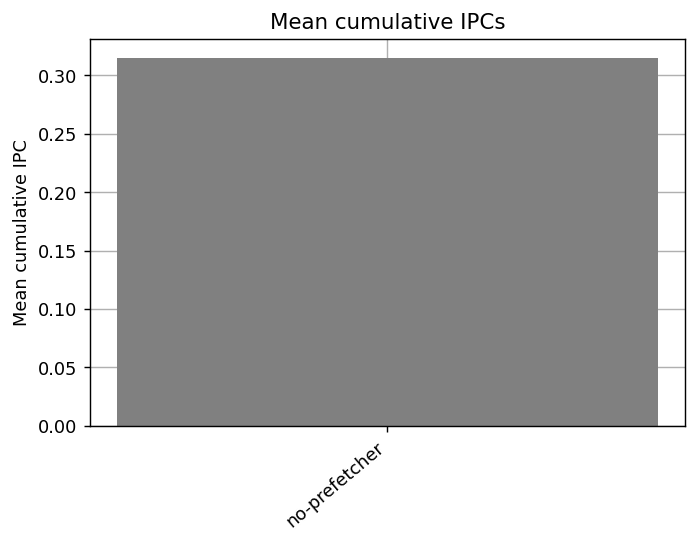

In [37]:
def plot_mean_ipcs(mean_ipcs, sweep_name=''):
    """Plot (weighted geometric) mean IPCs for a
    list of prefetchers.
    """
    fig, ax = plt.subplots(dpi=128)
    ax.grid()
    ax.set_axisbelow(True) # Plot grid under bars.
    
    labels = []
    i = 0
    for pf, pf_mean_ipc in mean_ipcs.items():
        ax.bar(
            i, pf_mean_ipc,
            color = 'gray'
        )
        labels.append(pf)
        i += 1
        
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=40, ha='right')
    
    title = 'Mean cumulative IPCs'
    if sweep_name:
        title += f' ({sweep_name})'
    ax.set_title(title)
    ax.set_ylabel('Mean cumulative IPC')
        
        
plot_mean_ipcs(mean_ipcs)

## Plot (weighted geometric) mean IPC speedups

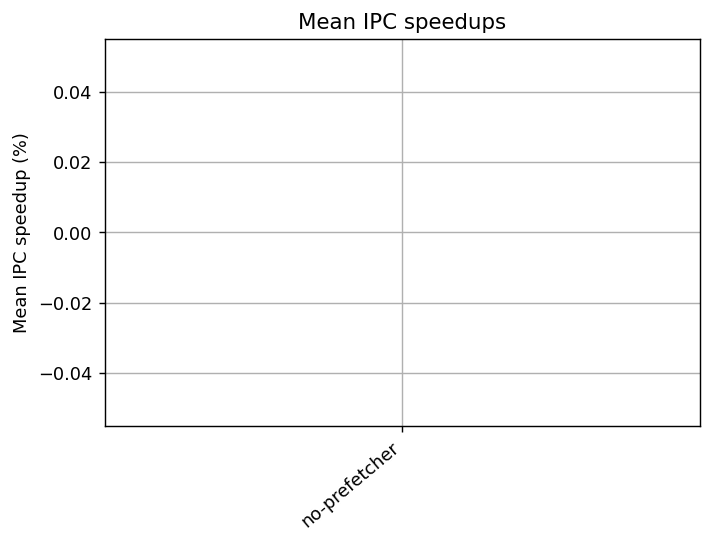

In [38]:
def plot_mean_ipc_speedups(mean_ipc_speedups, sweep_name=''):
    """Plot (weighted geometric) mean IPC speedups for a
    list of prefetchers.
    """
    fig, ax = plt.subplots(dpi=128)
    ax.grid()
    ax.set_axisbelow(True) # Plot grid under bars.
    
    labels = []
    i = 0
    for pf, pf_mean_ipc_speedup in mean_ipc_speedups.items():
        ax.bar(
            i, pf_mean_ipc_speedup * 100.,
            color = 'gray'
        )
        labels.append(pf)
        i += 1
        
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=40, ha='right')
    
    title = 'Mean IPC speedups'
    if sweep_name:
        title += f' ({sweep_name})'
    ax.set_title(title)
    ax.set_ylabel('Mean IPC speedup (%)')
        
        
plot_mean_ipc_speedups(mean_ipc_speedups)